In [1]:
"""
Improved/resilient training script for Respiratory Sound classification.
- Patient-wise split
- Smaller model capacity + L2 + BatchNorm + Dropout
- SpecAugment (time/freq masking)
- Class weights, label smoothing
- Proper evaluation over whole test set
- EarlyStopping + ModelCheckpoint + ReduceLROnPlateau
"""

'\nImproved/resilient training script for Respiratory Sound classification.\n- Patient-wise split\n- Smaller model capacity + L2 + BatchNorm + Dropout\n- SpecAugment (time/freq masking)\n- Class weights, label smoothing\n- Proper evaluation over whole test set\n- EarlyStopping + ModelCheckpoint + ReduceLROnPlateau\n'

In [2]:
import os
import wave
import math
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import scipy.io.wavfile as wf

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

import tensorflow as tf
from keras import backend as K
from keras import Sequential, optimizers
from keras.regularizers import l2
from keras.layers import Conv2D, Dense, Activation, Dropout, MaxPool2D, Flatten, LeakyReLU, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [3]:
DATASET_PATH = r"C:\Users\hp\Desktop\Biomed\Respiratory_Sound_Database"
AUDIO_PATH = os.path.join(DATASET_PATH, "audio_and_txt_files")
METADATA_PATH = os.path.join(DATASET_PATH, "patient_diagnosis.csv")
DEMOGRAPHIC_PATH = os.path.join(DATASET_PATH, "demographic_info.txt")

In [4]:
# Hyperparams
TARGET_SAMPLE_RATE = 22000
SAMPLE_LENGTH_SECONDS = 5
N_FILTERBANKS = 50
BATCH_SIZE = 64
N_EPOCHS = 50
LEARNING_RATE = 1e-4
SEED = 42

# SpecAugment params
SPEC_AUG_PROB = 0.5
TIME_MASK_WIDTH = 20
FREQ_MASK_WIDTH = 8
N_TIME_MASKS = 1
N_FREQ_MASKS = 1

# Regularization
L2_WEIGHT = 1e-4
DROPOUT_DENSE = 0.5
DROPOUT_CONV = 0.25
LABEL_SMOOTHING = 0.05

# Callbacks
PATIENCE_ES = 6
PATIENCE_RLR = 3


In [5]:
# reproducibility
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
print("Loading dataset files...")
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset path not found: {DATASET_PATH}")

# list files and build filenames (base without extension)
filenames = [s.split('.')[0] for s in os.listdir(path=AUDIO_PATH) if s.endswith('.txt')]
print(f"Found {len(filenames)} annotation files.")

# Load demographic (if available)
if os.path.exists(DEMOGRAPHIC_PATH):
    df_no_diagnosis = pd.read_csv(DEMOGRAPHIC_PATH, names=[
                         'Patient number', 'Age', 'Sex', 'Adult BMI (kg/m2)', 'Child Weight (kg)', 'Child Height (cm)'],
                         delimiter=' ', engine='python')
else:
    print("Warning: demographic_info.txt not found")

# Load diagnosis (metadata)
if os.path.exists(METADATA_PATH):
    diagnosis = pd.read_csv(METADATA_PATH, names=['Patient number', 'Diagnosis'])
else:
    diagnosis = None
    print("Warning: patient_diagnosis.csv not found (continuing without).")


Loading dataset files...
Found 920 annotation files.


**WAV reading helpers**

In [7]:
def bitrate_channels(lp_wave):
    # keep original approach (sampwidth / channels)
    bps = (lp_wave.getsampwidth() / lp_wave.getnchannels())
    return (bps, lp_wave.getnchannels())

def read24bitwave(lp_wave):
    nFrames = lp_wave.getnframes()
    buf = lp_wave.readframes(nFrames)
    reshaped = np.frombuffer(buf, np.int8).reshape(nFrames, -1)
    short_output = np.empty((nFrames, 2), dtype=np.int8)
    short_output[:, :] = reshaped[:, -2:]
    short_output = short_output.view(np.int16)
    return (lp_wave.getframerate(), np.divide(short_output, 32768).reshape(-1))

def extract2FloatArr(lp_wave, str_filename):
    (bps, channels) = bitrate_channels(lp_wave)
    # bps expected small set - keep original handling
    if bps in [1, 2, 4]:
        (rate, data) = wf.read(str_filename)
        divisor_dict = {1: 255, 2: 32768}
        if bps in [1, 2]:
            divisor = divisor_dict[bps]
            data = np.divide(data, float(divisor))
        return (rate, data)
    elif bps == 3:
        return read24bitwave(lp_wave)
    else:
        raise Exception('Unrecognized wave format: {} bytes per sample'.format(bps))

def read_wav_file(str_filename, target_rate):
    wav = wave.open(str_filename, mode='r')
    (sample_rate, data) = extract2FloatArr(wav, str_filename)
    # resample if needed
    if (sample_rate != target_rate):
        ( _ , data) = resample(sample_rate, data, target_rate)
    wav.close()
    return (target_rate, data.astype(np.float32))

def resample(current_rate, data, target_rate):
    # simple linear interpolation resample (kept from original)
    x_original = np.linspace(0, 100, len(data))
    x_resampled = np.linspace(0, 100, int(len(data) * (target_rate / current_rate)))
    resampled = np.interp(x_resampled, x_original, data)
    return (target_rate, resampled.astype(np.float32))

def slice_data(start, end, raw_data, sample_rate):
    max_ind = len(raw_data)
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data=[tokens], columns=['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names=['Start', 'End', 'Crackles', 'Wheezes'], delimiter='\t', engine='python')
    return (recording_info, recording_annotations)


**Mel Spectogram Helpers**

In [8]:
def Freq2Mel(freq):
    return 1125 * np.log(1 + freq / 700)

def Mel2Freq(mel):
    exponents = mel / 1125
    return 700 * (np.exp(exponents) - 1)

def VTLP_shift(mel_freq, alpha, f_high, sample_rate):
    nyquist_f = sample_rate / 2
    warp_factor = min(alpha, 1)
    threshold_freq = f_high * warp_factor / alpha
    lower = mel_freq * alpha
    higher = nyquist_f - (nyquist_f - mel_freq) * ((nyquist_f - f_high * warp_factor) / (nyquist_f - f_high * (warp_factor / alpha)))
    warped_mel = np.where(mel_freq <= threshold_freq, lower, higher)
    return warped_mel.astype(np.float32)

def GenerateMelFilterBanks(mel_space_freq, fft_bin_frequencies):
    n_filters = len(mel_space_freq) - 2
    coeff = []
    for mel_index in range(n_filters):
        m = int(mel_index + 1)
        filter_bank = []
        for f in fft_bin_frequencies:
            if (f < mel_space_freq[m-1]):
                hm = 0
            elif (f < mel_space_freq[m]):
                hm = (f - mel_space_freq[m-1]) / (mel_space_freq[m] - mel_space_freq[m-1])
            elif (f < mel_space_freq[m + 1]):
                hm = (mel_space_freq[m+1] - f) / (mel_space_freq[m + 1] - mel_space_freq[m])
            else:
                hm = 0
            filter_bank.append(hm)
        coeff.append(filter_bank)
    return np.array(coeff, dtype=np.float32)

def FFT2MelSpectrogram(f, Sxx, sample_rate, n_filterbanks, vtlp_params=None):
    (max_mel, min_mel) = (Freq2Mel(max(f)), Freq2Mel(min(f)))
    mel_bins = np.linspace(min_mel, max_mel, num=(n_filterbanks + 2))
    mel_freq = Mel2Freq(mel_bins)
    if (vtlp_params is None):
        filter_banks = GenerateMelFilterBanks(mel_freq, f)
    else:
        (alpha, f_high) = vtlp_params
        warped_mel = VTLP_shift(mel_freq, alpha, f_high, sample_rate)
        filter_banks = GenerateMelFilterBanks(warped_mel, f)
    mel_spectrum = np.matmul(filter_banks, Sxx)
    return (mel_freq[1:-1], np.log10(mel_spectrum + float(10e-12)))

def label2onehot(c_w_flags):
    c = c_w_flags[0]
    w = c_w_flags[1]
    if ((c == False) & (w == False)):
        return [1,0,0,0]
    elif ((c == True) & (w == False)):
        return [0,1,0,0]
    elif ((c == False) & (w == True)):
        return [0,0,1,0]
    else:
        return [0,0,0,1]

# SpecAugment implementation
def spec_augment(mel, time_w=TIME_MASK_WIDTH, freq_w=FREQ_MASK_WIDTH, n_time_masks=N_TIME_MASKS, n_freq_masks=N_FREQ_MASKS):
    mel = mel.copy()
    num_freq, num_time = mel.shape
    # freq masks
    for _ in range(n_freq_masks):
        f = np.random.randint(0, freq_w + 1)
        if f == 0 or num_freq - f <= 0:
            continue
        f0 = np.random.randint(0, num_freq - f + 1)
        mel[f0:f0+f, :] = 0
    # time masks
    for _ in range(n_time_masks):
        t = np.random.randint(0, time_w + 1)
        if t == 0 or num_time - t <= 0:
            continue
        t0 = np.random.randint(0, num_time - t + 1)
        mel[:, t0:t0+t] = 0
    return mel

# Convert sample (audio float array) to normalized mel + onehot
def sample2MelSpectrum(cycle_info, sample_rate, n_filters, vtlp_params=None, apply_specaugment=False):
    n_rows = 175
    n_window = 512
    (f, t, Sxx) = scipy.signal.spectrogram(cycle_info[0], fs=sample_rate, nfft=n_window, nperseg=n_window)
    Sxx = Sxx[:n_rows, :].astype(np.float32)
    mel_log = FFT2MelSpectrogram(f[:n_rows], Sxx, sample_rate, n_filters, vtlp_params)[1]
    # apply specaugment conditionally
    if apply_specaugment and (np.random.rand() < SPEC_AUG_PROB):
        mel_log = spec_augment(mel_log)
    mel_min = np.min(mel_log)
    mel_max = np.max(mel_log)
    diff = mel_max - mel_min
    norm_mel_log = (mel_log - mel_min) / diff if (diff > 0) else np.zeros(shape=(n_filters, Sxx.shape[1]))
    if (diff == 0):
        print('Warning: sample data is completely empty (zero variance)')
    labels = [cycle_info[1], cycle_info[2]]
    return (np.reshape(norm_mel_log, (n_filters, Sxx.shape[1], 1)).astype(np.float32),
            label2onehot(labels))

**Data preparation functions**

In [9]:
def get_sound_samples(recording_annotations, file_name, root, sample_rate):
    sample_data = [file_name]
    (rate, data) = read_wav_file(os.path.join(root, file_name + '.wav'), sample_rate)
    for i in range(len(recording_annotations.index)):
        row = recording_annotations.loc[i]
        start = row['Start']
        end = row['End']
        crackles = row['Crackles']
        wheezes = row['Wheezes']
        audio_chunk = slice_data(start, end, data, rate)
        sample_data.append((audio_chunk, start, end, crackles, wheezes))
    return sample_data

def split_and_pad(original, desiredLength, sampleRate):
    output_buffer_length = int(desiredLength * sampleRate)
    soundclip = original[0]
    n_samples = len(soundclip)
    if n_samples == 0:
        return []
    total_length = n_samples / sampleRate
    n_slices = int(math.ceil(total_length / desiredLength))
    samples_per_slice = n_samples // n_slices if n_slices > 0 else n_samples
    src_start = 0
    output = []
    for i in range(n_slices):
        src_end = min(src_start + samples_per_slice, n_samples)
        length = src_end - src_start
        if length <= 0:
            break
        copy = generate_padded_samples(soundclip[src_start:src_end], output_buffer_length)
        output.append((copy, original[1], original[2]))
        src_start += length
    return output

def generate_padded_samples(source, output_length):
    copy = np.zeros(output_length, dtype=np.float32)
    src_length = len(source)
    if src_length == 0:
        return copy
    frac = src_length / output_length
    if frac < 0.5:
        cursor = 0
        while (cursor + src_length) < output_length:
            copy[cursor:(cursor + src_length)] = source[:]
            cursor += src_length
    else:
        copy[:src_length] = source[:src_length]
    return copy

def gen_time_stretch(original, sample_rate, max_percent_change):
    stretch_amount = 1 + np.random.uniform(-1, 1) * (max_percent_change / 100)
    (_, stretched) = resample(sample_rate, original, int(sample_rate * stretch_amount))
    return stretched

def augment_list(audio_with_labels, sample_rate, percent_change, n_repeats):
    augmented_samples = []
    for i in range(n_repeats):
        addition = [(gen_time_stretch(t[0], sample_rate, percent_change), t[1], t[2]) for t in audio_with_labels]
        augmented_samples.extend(addition)
    return augmented_samples

def split_and_pad_and_apply_mel_spect(original, desiredLength, sampleRate, VTLP_alpha_range=None, VTLP_high_freq_range=None, n_repeats=1, specaugment=False):
    output = []
    for i in range(n_repeats):
        for d in original:
            lst_result = split_and_pad(d, desiredLength, sampleRate)
            if((VTLP_alpha_range is None) | (VTLP_high_freq_range is None)):
                VTLP_params = None
            else:
                alpha = np.random.uniform(VTLP_alpha_range[0], VTLP_alpha_range[1])
                high_freq = np.random.uniform(VTLP_high_freq_range[0], VTLP_high_freq_range[1])
                VTLP_params = (alpha, high_freq)
            # apply sample2MelSpectrum (specaugment applied inside sample2MelSpectrum when requested)
            freq_result = [sample2MelSpectrum(d, sampleRate, N_FILTERBANKS, VTLP_params, apply_specaugment=specaugment) for d in lst_result]
            output.extend(freq_result)
    return output

def extract_all_training_samples(filenames, annotation_dict, root, target_rate, desired_length, train_test_ratio=0.2):
    cycle_list = []
    for file in filenames:
        data = get_sound_samples(annotation_dict[file], file, root, target_rate)
        cycles_with_labels = [(d[0], d[3], d[4]) for d in data[1:]]
        cycle_list.extend(cycles_with_labels)

    no_labels = [c for c in cycle_list if ((c[1] == 0) & (c[2] == 0))]
    c_only = [c for c in cycle_list if ((c[1] == 1) & (c[2] == 0))]
    w_only = [c for c in cycle_list if ((c[1] == 0) & (c[2] == 1))]
    c_w = [c for c in cycle_list if ((c[1] == 1) & (c[2] == 1))]

    none_train, none_test = train_test_split(no_labels, test_size=train_test_ratio, random_state=SEED)
    c_train, c_test = train_test_split(c_only, test_size=train_test_ratio, random_state=SEED)
    w_train, w_test = train_test_split(w_only, test_size=train_test_ratio, random_state=SEED)
    c_w_train, c_w_test = train_test_split(c_w, test_size=train_test_ratio, random_state=SEED)

    # augment minority classes (time stretch)
    w_stretch = w_train + augment_list(w_train, target_rate, 10, 1)
    c_w_stretch = c_w_train + augment_list(c_w_train, target_rate, 10, 1)

    vtlp_alpha = [0.9, 1.1]
    vtlp_upper_freq = [3200, 3800]

    train_none = (split_and_pad_and_apply_mel_spect(none_train, desired_length, target_rate) +
                   split_and_pad_and_apply_mel_spect(none_train, desired_length, target_rate, vtlp_alpha))
    train_c = (split_and_pad_and_apply_mel_spect(c_train, desired_length, target_rate) +
               split_and_pad_and_apply_mel_spect(c_train, desired_length, target_rate, vtlp_alpha, vtlp_upper_freq, n_repeats=3))
    train_w = (split_and_pad_and_apply_mel_spect(w_stretch, desired_length, target_rate) +
               split_and_pad_and_apply_mel_spect(w_stretch, desired_length, target_rate, vtlp_alpha, vtlp_upper_freq, n_repeats=4))
    train_c_w = (split_and_pad_and_apply_mel_spect(c_w_stretch, desired_length, target_rate) +
                 split_and_pad_and_apply_mel_spect(c_w_stretch, desired_length, target_rate, vtlp_alpha, vtlp_upper_freq, n_repeats=7))

    # Apply specaugment probability only on training sets by regenerating with specaugment=True and small repeats
    train_none_aug = split_and_pad_and_apply_mel_spect(none_train, desired_length, target_rate, None, None, n_repeats=1, specaugment=True)
    # concatenate training datasets (originally they had spec augment via repeated calls too)
    # We'll use the non-aug versions above and allow the generator to use augmented copies where needed.
    train_dict = {'none': train_none + train_none_aug, 'crackles': train_c, 'wheezes': train_w, 'both': train_c_w}

    test_none = split_and_pad_and_apply_mel_spect(none_test, desired_length, target_rate)
    test_c = split_and_pad_and_apply_mel_spect(c_test, desired_length, target_rate)
    test_w = split_and_pad_and_apply_mel_spect(w_test, desired_length, target_rate)
    test_c_w = split_and_pad_and_apply_mel_spect(c_w_test, desired_length, target_rate)

    test_dict = {'none': test_none, 'crackles': test_c, 'wheezes': test_w, 'both': test_c_w}

    return [train_dict, test_dict]

**Generators**

In [10]:
class data_generator():
    def __init__(self, sound_clips, strides):
        self.clips = sound_clips
        self.strides = strides
        self.lengths = [len(arr) for arr in sound_clips]

    def n_available_samples(self):
        # ensure nonzero
        if len(self.lengths) == 0:
            return 0
        return int(min(np.divide(self.lengths, self.strides))) * 4

    def generate_keras(self, batch_size, yield_sample_weight=True):
        """
        Yields (X_batch, y_batch, sample_weights) when yield_sample_weight=True
        or (X_batch, y_batch) when False.
        Uses global `class_weights` dict to map class index -> weight.
        """
        cursor = [0,0,0,0]
        while True:
            i = 0
            X, y = [], []
            for c in range(batch_size):
                cat_length = self.lengths[i]
                if cat_length == 0:
                    # safety: skip if no samples
                    X.append(np.zeros((N_FILTERBANKS, 1, 1), dtype=np.float32))
                    y.append([1,0,0,0])
                    i = (i + 1) % 4
                    continue
                cat_clips = self.clips[i]
                cat_stride = self.strides[i]
                cat_advance = np.random.randint(low=1, high=cat_stride + 1)
                clip = cat_clips[(cursor[i] + cat_advance) % cat_length]
                cursor[i] = (cursor[i] + self.strides[i]) % cat_length
                s = (self.rollFFT(clip))
                X.append(s[0])
                y.append(s[1])
                i = (i + 1) % 4

            X_batch = np.reshape(X, (batch_size, X[0].shape[0], X[0].shape[1], 1))
            y_batch = np.reshape(y, (batch_size, 4))

            if yield_sample_weight:
                # per-sample weights from the class_weights dict
                class_indices = np.argmax(y_batch, axis=1)
                sample_weights = np.array([float(class_weights[int(ci)]) for ci in class_indices], dtype=np.float32)
                yield (X_batch, y_batch, sample_weights)
            else:
                yield (X_batch, y_batch)


    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col) if n_col>0 else 0
        return ((np.roll(fft, pivot, axis=1)), fft_info[1])

class feed_all():
    def __init__(self, sound_clips, roll=True):
        merged = []
        for arr in sound_clips:
            merged.extend(arr)
        np.random.shuffle(merged)
        self.clips = merged
        self.nclips = len(merged)
        self.roll = roll

    def n_available_samples(self):
        return len(self.clips)

    def generate_keras(self, batch_size, yield_sample_weight=False):
        """
        Yields (X_batch, y_batch, sample_weights) if yield_sample_weight=True,
        otherwise yields (X_batch, y_batch).
        For validation/testing call with yield_sample_weight=False.
        """
        i = 0
        while True:
            X, y = [], []
            for b in range(batch_size):
                if self.nclips == 0:
                    X.append(np.zeros((N_FILTERBANKS, 1, 1), dtype=np.float32))
                    y.append([1,0,0,0])
                    continue
                clip = self.clips[i]
                i = (i + 1) % self.nclips
                if(self.roll):
                    s = (self.rollFFT(clip))
                    X.append(s[0])
                    y.append(s[1])
                else:
                    X.append(clip[0])
                    y.append(clip[1])

            X_batch = np.reshape(X, (batch_size, X[0].shape[0], X[0].shape[1], 1))
            y_batch = np.reshape(y, (batch_size, 4))

            if yield_sample_weight:
                class_indices = np.argmax(y_batch, axis=1)
                sample_weights = np.array([float(class_weights[int(ci)]) for ci in class_indices], dtype=np.float32)
                yield (X_batch, y_batch, sample_weights)
            else:
                yield (X_batch, y_batch)




    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col) if n_col>0 else 0
        return ((np.roll(fft, pivot, axis=1)), fft_info[1])


**Prepare annotations & patient-wise split**

In [11]:
print("Extracting annotations and building recording dict...")
i_list = []
rec_annotations_dict = {}
for s in filenames:
    (i, a) = Extract_Annotation_Data(s, AUDIO_PATH)
    i_list.append(i)
    rec_annotations_dict[s] = a
# recording_info is concatenation of i_list if needed
recording_info = pd.concat(i_list, axis=0, ignore_index=True)

# helper to extract patient id from filename (first token)
def patient_from_filename(fn):
    return fn.split('_')[0]

all_patients = np.unique([patient_from_filename(f) for f in filenames])
train_patients, test_patients = train_test_split(all_patients, test_size=0.2, random_state=SEED)
train_files = [f for f in filenames if patient_from_filename(f) in train_patients]
test_files  = [f for f in filenames if patient_from_filename(f) in test_patients]

Extracting annotations and building recording dict...


In [12]:
print(f"Patients total: {len(all_patients)} | Train patients: {len(train_patients)} | Test patients: {len(test_patients)}")
print(f"Train files: {len(train_files)} | Test files: {len(test_files)}")

Patients total: 126 | Train patients: 100 | Test patients: 26
Train files: 706 | Test files: 214


**Extract training/test spectrograms**

In [13]:
print("Preparing training and test samples (mel spectrograms). This may take time...")
sample_dict_train_test = extract_all_training_samples(train_files, rec_annotations_dict, AUDIO_PATH, TARGET_SAMPLE_RATE, SAMPLE_LENGTH_SECONDS)
training_clips = sample_dict_train_test[0]
test_clips = sample_dict_train_test[1]


Preparing training and test samples (mel spectrograms). This may take time...


In [14]:
def print_sample_count(src_dict):
    print('none:{}\ncrackles:{}\nwheezes:{}\nboth:{}'.format(len(src_dict['none']),
                                                            len(src_dict['crackles']),
                                                            len(src_dict['wheezes']),
                                                            len(src_dict['both'])))

print('\n[Training set counts]')
print_sample_count(training_clips)
print('\n[Test set counts]')
print_sample_count(test_clips)



[Training set counts]
none:7134
crackles:4348
wheezes:5445
both:4536

[Test set counts]
none:595
crackles:273
wheezes:137
both:70


In [15]:
# shuffle per-category
for key in ['none','crackles','wheezes','both']:
    np.random.shuffle(training_clips[key])
    np.random.shuffle(test_clips[key])

# generator instances
train_gen = data_generator([training_clips['none'], training_clips['crackles'], training_clips['wheezes'], training_clips['both']], [1,1,1,1])
test_gen = feed_all([test_clips['none'], test_clips['crackles'], test_clips['wheezes'], test_clips['both']], roll=False)

**Compute class weights from training data**

In [16]:
def gather_label_indices_from_clips(clips_dict):
    labels = []
    for idx, cls in enumerate(['none','crackles','wheezes','both']):
        arr = clips_dict[cls]
        labels.extend([idx] * len(arr))
    return np.array(labels)

train_label_indices = gather_label_indices_from_clips(training_clips)
if len(train_label_indices) == 0:
    raise Exception("No training samples found. Check data extraction.")

classes = np.array([0,1,2,3])
class_weights_arr = compute_class_weight('balanced', classes=classes, y=train_label_indices)
class_weights = dict(enumerate(class_weights_arr))
print("Computed class weights:", class_weights)


Computed class weights: {0: np.float64(0.7521376506868517), 1: np.float64(1.234073137074517), 2: np.float64(0.98544536271809), 3: np.float64(1.1829254850088184)}


**Build Model**

In [17]:
print("Building model...")
# infer sample shapes
if len(training_clips['none']) == 0:
    raise Exception("No 'none' training samples found. Can't infer shape.")
sample_height = training_clips['none'][0][0].shape[0]
sample_width = training_clips['none'][0][0].shape[1]

K.clear_session()

Building model...



In [18]:
model = Sequential()
model.add(Conv2D(128, (7,11), strides=(2,2), padding='same', kernel_regularizer=l2(L2_WEIGHT), input_shape=(sample_height, sample_width, 1)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(padding='same'))
model.add(Dropout(DROPOUT_CONV))

model.add(Conv2D(256, (5,5), padding='same', kernel_regularizer=l2(L2_WEIGHT)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(padding='same'))
model.add(Dropout(DROPOUT_CONV))

model.add(Conv2D(256, (1,1), padding='same', kernel_regularizer=l2(L2_WEIGHT)))
model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=l2(L2_WEIGHT)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(padding='same'))
model.add(Dropout(DROPOUT_CONV))

model.add(Conv2D(512, (1,1), padding='same', kernel_regularizer=l2(L2_WEIGHT)))
model.add(Conv2D(512, (3,3), padding='same', activation='relu', kernel_regularizer=l2(L2_WEIGHT)))
model.add(Conv2D(512, (1,1), padding='same', kernel_regularizer=l2(L2_WEIGHT)))
model.add(Conv2D(512, (3,3), padding='same', activation='relu', kernel_regularizer=l2(L2_WEIGHT)))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())

# reduce dense size
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(L2_WEIGHT)))
model.add(Dropout(DROPOUT_DENSE))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(L2_WEIGHT)))
model.add(Dense(4, activation='softmax'))

opt = optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING),
              metrics=['accuracy'])

print(model.summary())

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 123, 128)   │         9,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25, 123, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 25, 123, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 62, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 62, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 13, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 31, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 31, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 31, 256)     │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 31, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 31, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7, 31, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 16, 512)     │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 16, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 16, 512)     │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 16, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,518,212 (59.20 MB)

 Trainable params: 15,516,932 (59.19 MB)

 Non-trainable params: 1,280 (5.00 KB)

None


**Callbacks**

In [19]:
chk = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
es  = EarlyStopping(monitor='val_accuracy', patience=PATIENCE_ES, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=PATIENCE_RLR, min_lr=1e-7, verbose=1)


**Training**

In [20]:
steps_train = max(1, train_gen.n_available_samples() // BATCH_SIZE)
steps_val = max(1, test_gen.n_available_samples() // BATCH_SIZE)

print(f"Training steps_per_epoch: {steps_train}, validation_steps: {steps_val}")

history = model.fit(train_gen.generate_keras(BATCH_SIZE, yield_sample_weight=True),
                    steps_per_epoch=steps_train,
                    validation_data=test_gen.generate_keras(BATCH_SIZE, yield_sample_weight=False),
                    validation_steps=steps_val,
                    epochs=N_EPOCHS,
                    callbacks=[chk, es, rlr],
                    verbose=1)



Training steps_per_epoch: 271, validation_steps: 16
Epoch 1/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3451 - loss: 1.9445
Epoch 1: val_accuracy improved from None to 0.25684, saving model to best_model.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 749s 3s/step - accuracy: 0.3801 - loss: 1.8383 - val_accuracy: 0.2568 - val_loss: 2.1126 - learning_rate: 1.0000e-04
Epoch 2/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4402 - loss: 1.7358
Epoch 2: val_accuracy improved from 0.25684 to 0.26465, saving model to best_model.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 726s 3s/step - accuracy: 0.4539 - loss: 1.7077 - val_accuracy: 0.2646 - val_loss: 2.2882 - learning_rate: 1.0000e-04
Epoch 3/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4996 - loss: 1.6292
Epoch 3: val_accuracy improved from 0.26465 to 0.28223, saving model to best_model.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 737s 3s/step - accuracy: 0.5157 - loss: 1.6064 - val_accuracy: 0.2822 - val_loss: 2.2607 - learning_rate: 1.

In [21]:
# Save training history
pd.DataFrame(history.history).to_csv('training_history_improved.csv', index=False)
print("Saved training history to 'training_history_improved.csv'")

Saved training history to 'training_history_improved.csv'


**Evaluation over full test set**

In [22]:
print("Evaluating model on the full test set...")
# create generator without rolling (we already built test_gen with roll=False)
steps = max(1, test_gen.n_available_samples() // BATCH_SIZE)
gen = test_gen.generate_keras(BATCH_SIZE)

y_true_list = []
y_pred_list = []

for _ in range(steps):
    Xb, yb = next(gen)
    preds = model.predict(Xb)
    y_true_list.append(yb)
    y_pred_list.append(preds)

y_true = np.vstack(y_true_list)
y_pred = np.vstack(y_pred_list)

labels = np.argmax(y_true, axis=1)
predictions_classes = np.argmax(y_pred, axis=1)

# metrics
overall_accuracy = accuracy_score(labels, predictions_classes)
precision, recall, f1, support = precision_recall_fscore_support(labels, predictions_classes, zero_division=0)

Evaluating model on the full test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


In [23]:
print("\nClassification Report:")
class_names = ['none','crackles','wheezes','both']
print(classification_report(labels, predictions_classes, target_names=class_names, zero_division=0))
print(f"\nOverall Test Accuracy: {overall_accuracy*100:.2f}%")


Classification Report:
              precision    recall  f1-score   support

        none       0.87      0.63      0.73       563
    crackles       0.54      0.87      0.66       263
     wheezes       0.61      0.55      0.58       130
        both       0.60      0.62      0.61        68

    accuracy                           0.68      1024
   macro avg       0.65      0.67      0.65      1024
weighted avg       0.73      0.68      0.69      1024


Overall Test Accuracy: 68.36%


In [24]:
cm = confusion_matrix(labels, predictions_classes)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[357 166  36   4]
 [ 22 229   6   6]
 [ 28  12  72  18]
 [  3  19   4  42]]


In [25]:
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})
print("\nPer-class metrics:\n", metrics_df.to_string(index=False))


Per-class metrics:
    Class  Precision   Recall  F1-Score  Support
    none   0.870732 0.634103  0.733813      563
crackles   0.537559 0.870722  0.664731      263
 wheezes   0.610169 0.553846  0.580645      130
    both   0.600000 0.617647  0.608696       68


In [26]:
# Save evaluation metrics
eval_results = {
    'overall_accuracy': float(overall_accuracy),
    'class_names': class_names,
    'precision': precision.tolist(),
    'recall': recall.tolist(),
    'f1_score': f1.tolist(),
    'support': support.tolist(),
    'confusion_matrix': cm.tolist()
}
with open('evaluation_metrics_improved.json', 'w') as f:
    json.dump(eval_results, f, indent=4)
print("Saved evaluation metrics to 'evaluation_metrics_improved.json'")

Saved evaluation metrics to 'evaluation_metrics_improved.json'


In [28]:
# Save model weights & architecture
model.save('respiratory_sound_model_improved.keras')
model.save_weights('respiratory_sound_weights_improved.weights.h5')
with open('respiratory_sound_architecture_improved.json', 'w') as jf:
    jf.write(model.to_json())
print("Saved improved model & weights.")

Saved improved model & weights.


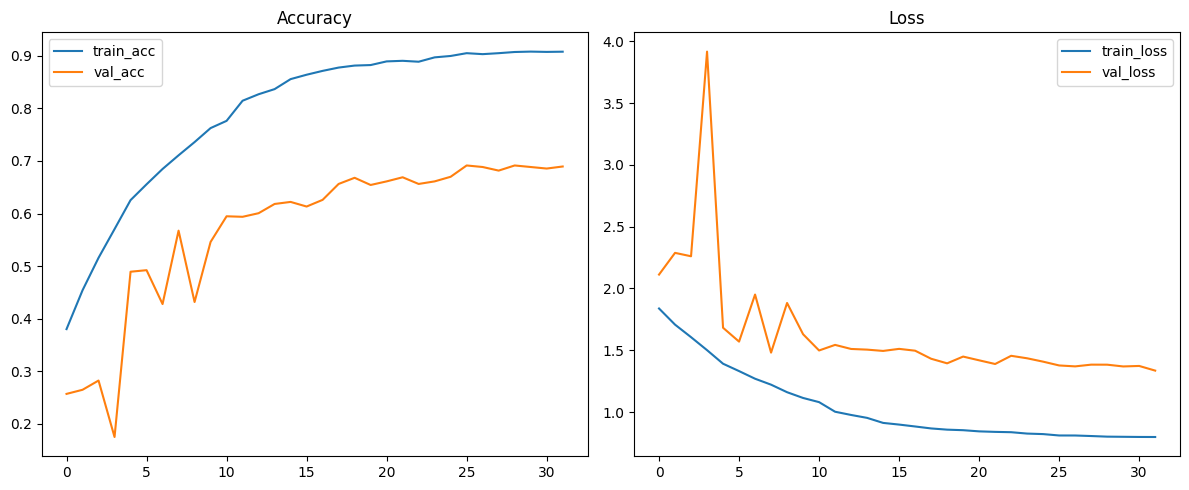

In [30]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history.get('loss', []), label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('training_history_improved.png', dpi=200)
plt.show()